In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

# Preparing Data

In [5]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 10s 0us/step


In [6]:
print(data_dir)

/root/.keras/datasets/flower_photos


/root/.keras/datasets/flower_photos/roses/6163179241_f093f45d95_n.jpg


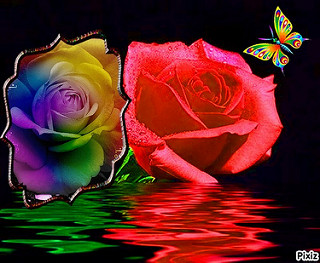

In [9]:
roses = list(data_dir.glob("roses/*"))
print(roses[0])
PIL.Image.open(str(roses[0]))

In [10]:
img_height, img_width = 180,180
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Training Model

In [15]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling="avg",
    classes=5,
    weights="imagenet"
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation="relu"))
resnet_model.add(Dense(5, activation="softmax"))

94765736/94765736 [==============================] - 5s 0us/step


In [16]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 5)                2565      
 pper)                                                           
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
__________________________________

In [18]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
epochs=10
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 23s 121ms/step - loss: 0.8159 - accuracy: 0.7708 - val_loss: 0.4041 - val_accuracy: 0.8529
Epoch 2/10
92/92 [==============================] - 9s 98ms/step - loss: 0.2834 - accuracy: 0.8971 - val_loss: 0.3777 - val_accuracy: 0.8583
Epoch 3/10
92/92 [==============================] - 9s 91ms/step - loss: 0.1772 - accuracy: 0.9397 - val_loss: 0.3764 - val_accuracy: 0.8747
Epoch 4/10
92/92 [==============================] - 10s 110ms/step - loss: 0.1098 - accuracy: 0.9646 - val_loss: 0.4845 - val_accuracy: 0.8556
Epoch 5/10
92/92 [==============================] - 13s 133ms/step - loss: 0.0597 - accuracy: 0.9860 - val_loss: 0.3906 - val_accuracy: 0.8706
Epoch 6/10
92/92 [==============================] - 11s 114ms/step - loss: 0.0414 - accuracy: 0.9922 - val_loss: 0.3988 - val_accuracy: 0.8828
Epoch 7/10
92/92 [==============================] - 9s 92ms/step - loss: 0.0217 - accuracy: 0.9963 - val_loss: 0.4275 - val_accuracy: 0.8815
Epoch

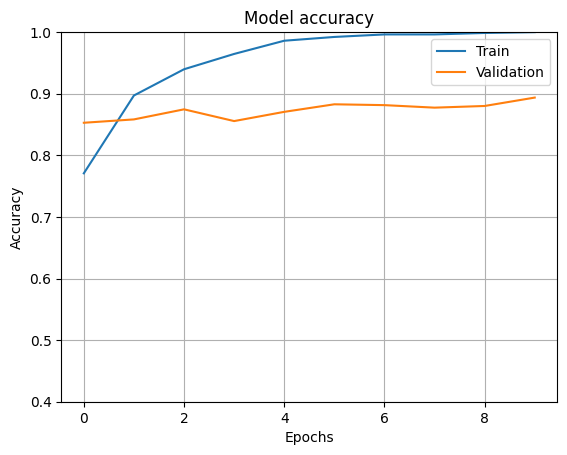

In [21]:
fig1 = plt.gcf()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

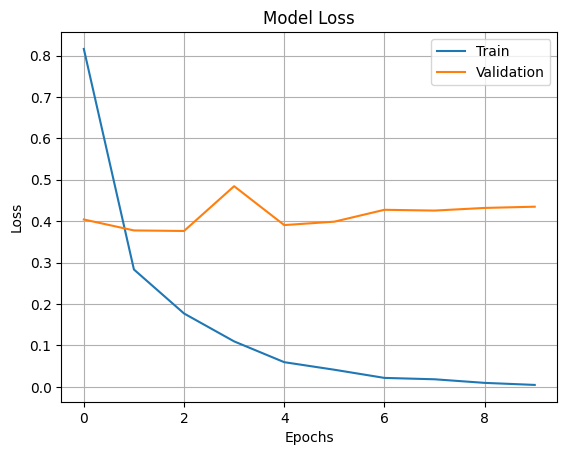

In [23]:
fig1 = plt.gcf()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

# Making Predictions

In [25]:
import cv2
image = cv2.imread(str(roses[0]))
image_resized=cv2.resize(image, (img_height, img_width))
image=np.expand_dims(image_resized,axis=0)

In [26]:
pred=resnet_model.predict(image)

print(pred)

1/1 [==============================] - 2s 2s/step
[[9.4770147e-12 3.7668160e-11 9.9998939e-01 1.8988795e-09 1.0586441e-05]]


In [27]:
output_class = class_names[np.argmax(pred)]
print(f"Predicted class is {output_class}")

Predicted class is roses


# Fine Tuning

In [29]:
pretrained_model.trainable = True
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 5)                2565      
 pper)                                                           
                                                                 
Total params: 24,639,365
Trainable params: 24,586,245
Non-trainable params: 53,120
_____________________________________

In [30]:
epochs=5
history_tuned = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 9s 92ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4409 - val_accuracy: 0.8910
Epoch 2/5
92/92 [==============================] - 10s 101ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4443 - val_accuracy: 0.8924
Epoch 3/5
92/92 [==============================] - 10s 100ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4491 - val_accuracy: 0.8910
Epoch 4/5
92/92 [==============================] - 11s 112ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.4556 - val_accuracy: 0.8910
Epoch 5/5
92/92 [==============================] - 9s 91ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4593 - val_accuracy: 0.8896


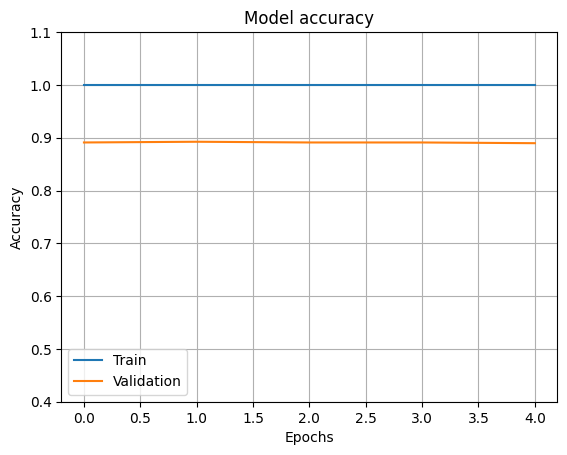

In [32]:
fig1 = plt.gcf()
plt.plot(history_tuned.history["accuracy"])
plt.plot(history_tuned.history["val_accuracy"])
plt.axis(ymin=0.4,ymax=1.1)
plt.grid()
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

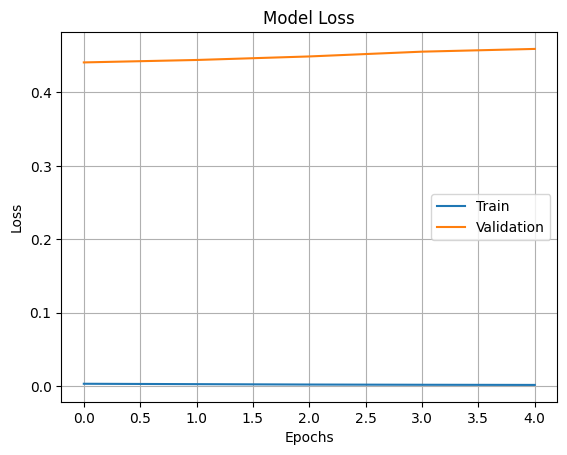

In [33]:
fig1 = plt.gcf()
plt.plot(history_tuned.history["loss"])
plt.plot(history_tuned.history["val_loss"])
plt.grid()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()